In [1]:
import numpy as np
import pandas as pd
# from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (22, 9)
plt.rcParams["font.size"] = 25
import seaborn as sns
sns.set()#seabornのスタイルをセット
import matplotlib.image as mpimg

## Contextual Bandit

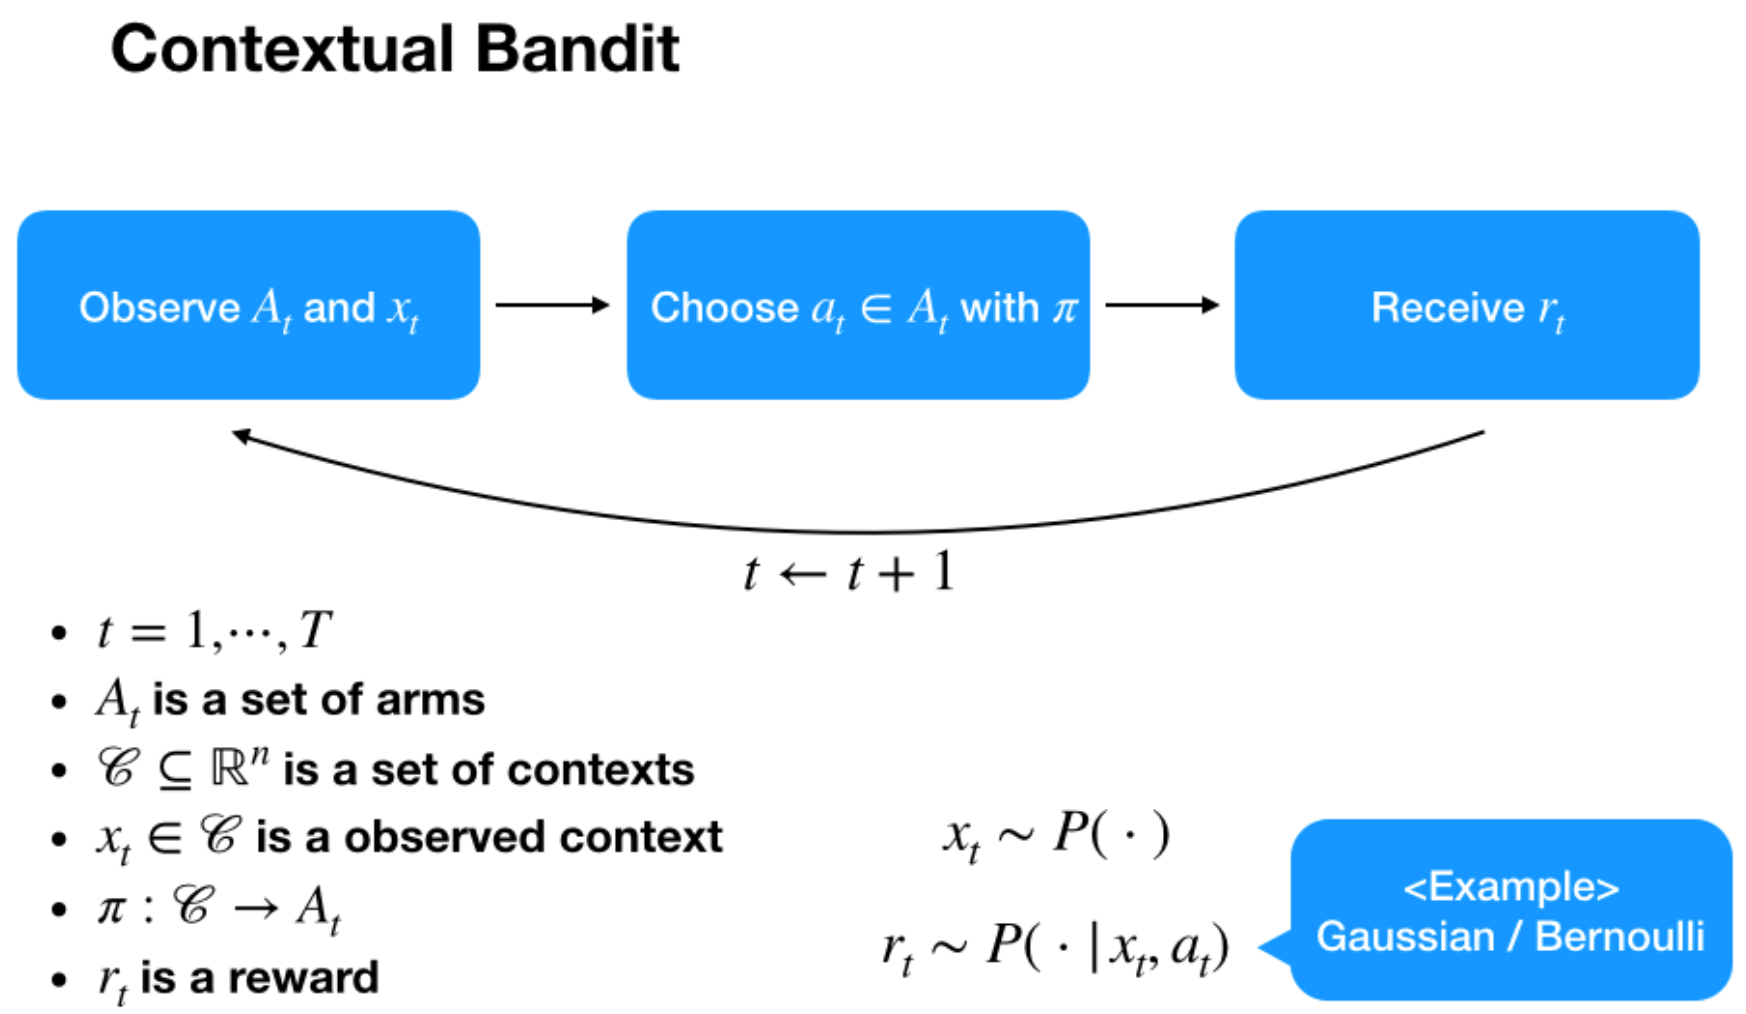

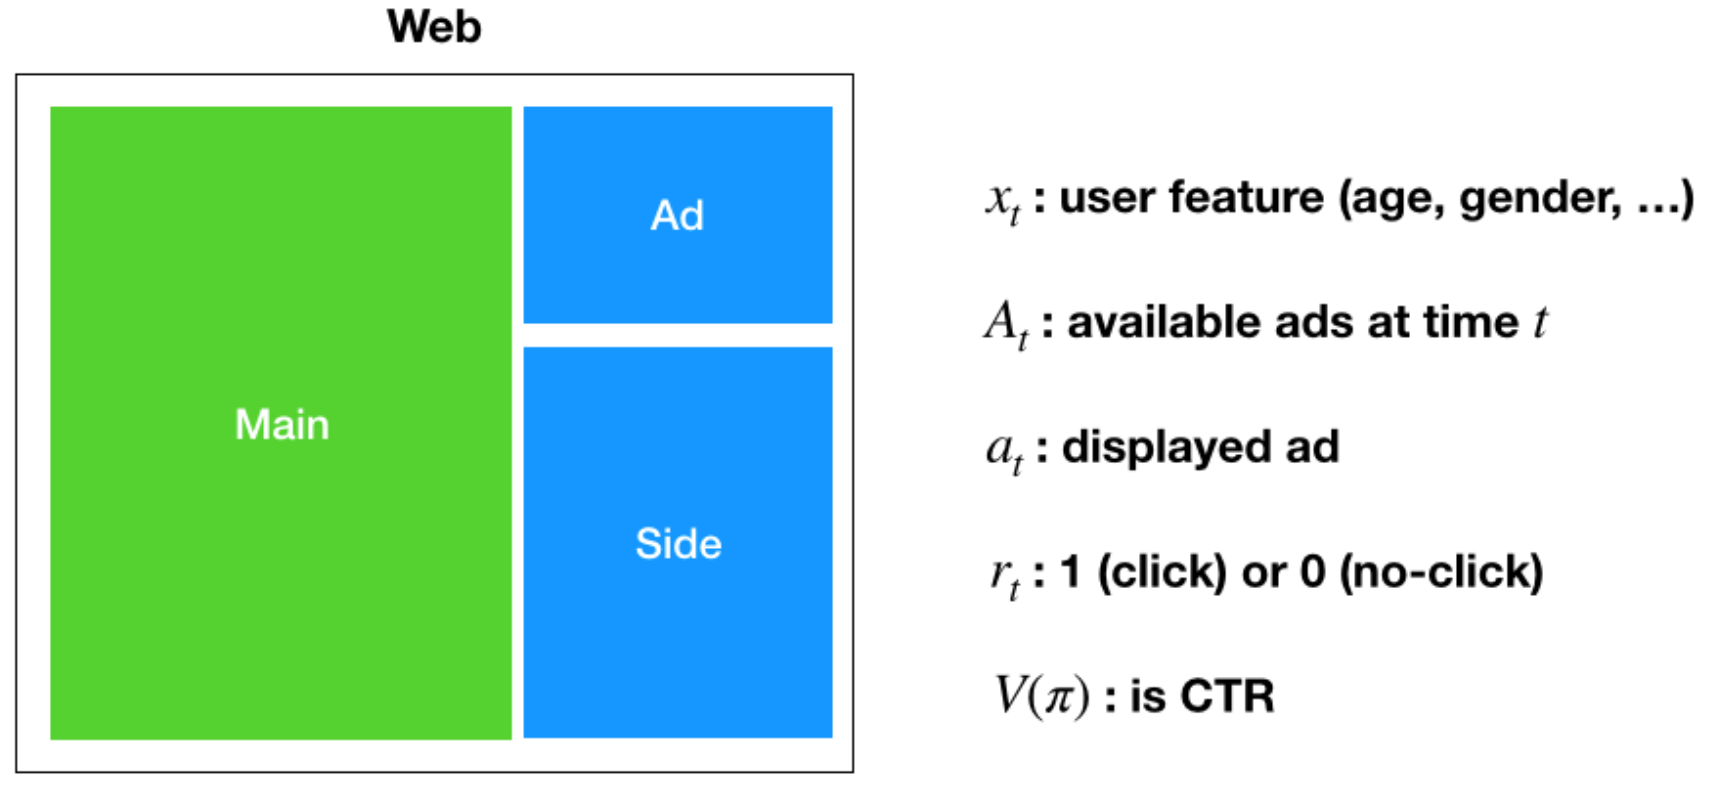

## 共通するパラメータ（サンプル数n、特徴量の次元d、アーム数K、アームの係数θ）

In [2]:
np.random.seed(23)

n = 10000  # number of data
d = 10   # number of features(age, gender, ..)
K = 5  # number of actions

X = np.random.random((n, d))# 回数*特徴数
theta = np.random.normal(0, 1, (K, d))# reward算出におけるfeartureの係数。正規分布の乱数、平均0分散1、K*d

print("X=", X.shape)
print("theta=", theta.shape)

X= (10000, 10)
theta= (5, 10)


In [3]:
X

array([[0.51729788, 0.9469626 , 0.76545976, ..., 0.39244247, 0.61805235,
        0.41193009],
       [0.00246488, 0.88403218, 0.88494754, ..., 0.06507544, 0.29474446,
        0.28793444],
       [0.82246634, 0.62618304, 0.11047771, ..., 0.34648944, 0.86978508,
        0.42860181],
       ...,
       [0.13604783, 0.06158716, 0.457482  , ..., 0.50691957, 0.20328999,
        0.66995597],
       [0.11315252, 0.95273143, 0.55511525, ..., 0.15299519, 0.11689052,
        0.67221876],
       [0.6608973 , 0.25365461, 0.756748  , ..., 0.2912929 , 0.06262878,
        0.20686539]])

In [4]:
y = np.dot(X, theta.T)#(10000*5)
print("y=",y.shape)

y= (10000, 5)


In [5]:
y

array([[-2.46286368, -0.01504046,  1.90609142,  1.1203863 , -1.04720262],
       [-0.02440912,  0.38252257,  3.96642901,  1.15524699, -1.62571777],
       [-1.65258886,  1.36761881,  2.11574313, -0.10463437,  0.75664915],
       ...,
       [ 0.37194304,  1.14848053,  2.20383457,  2.06759798, -1.74702957],
       [ 0.12200913,  0.64373552,  1.36880874,  1.53321252, -0.68783987],
       [-0.77782172,  0.14578758,  0.51092157,  0.5749758 , -0.42616881]])

In [6]:
optimal_a = np.array(y.argmax(axis=1), dtype=int)#報酬yが最大となる列

optimal_a

array([2, 2, 2, ..., 2, 3, 3])

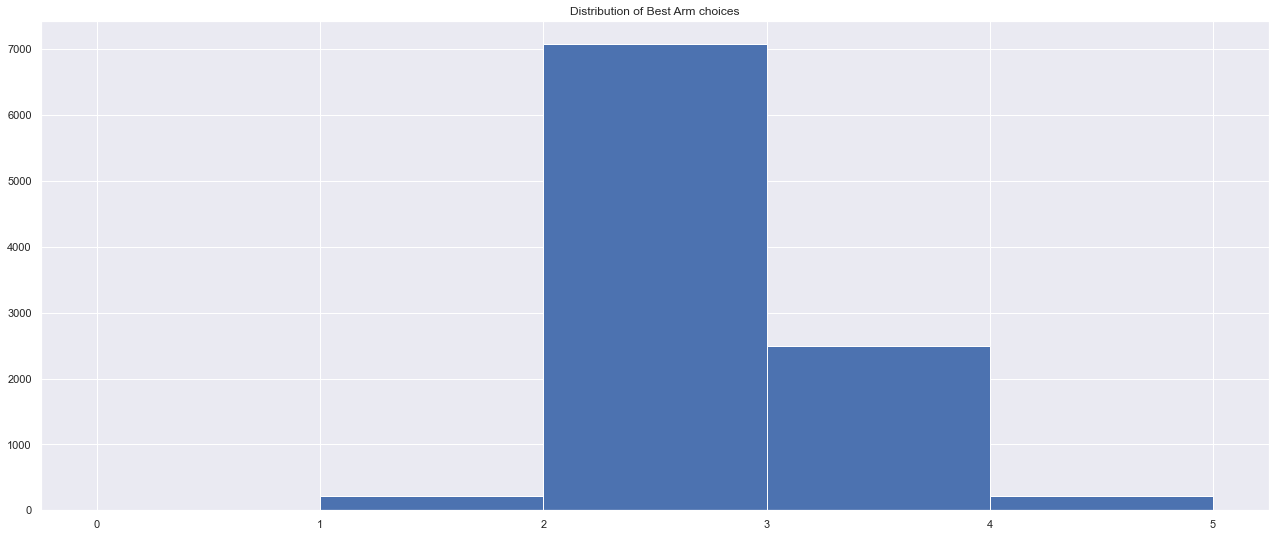

In [7]:
plt.title("Distribution of Best Arm choices")
plt.hist(optimal_a, bins=range(0, K+1));

## LinUCB (disjoint model )
- 特徴量間で共有する係数θがないモデル
-　以下のサイトを参考に作成。サイトでは元論文の疑似コードを実装しており、テキスト「バンディット問題の理論とアルゴリズム」と異なるため、テキストに合わせ修正した。
- https://research.miidas.jp/2020/03/contextual-bandit-linucb-lints/
- (元論文)　A Contextual-Bandit Approach to Personalized News Article Recommendation　https://arxiv.org/pdf/1003.0146.pdf

In [13]:
from tqdm import tqdm_notebook as tqdm# 進捗バーの表示
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


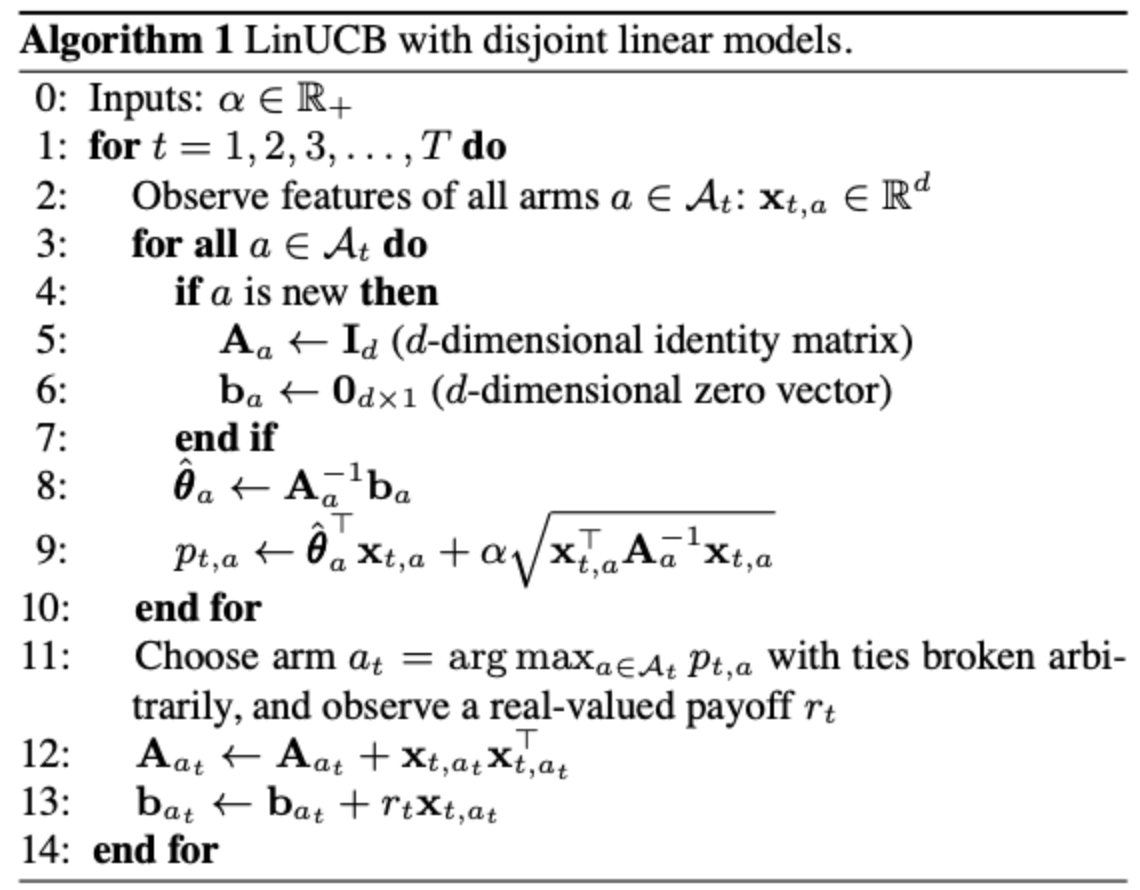

<div>
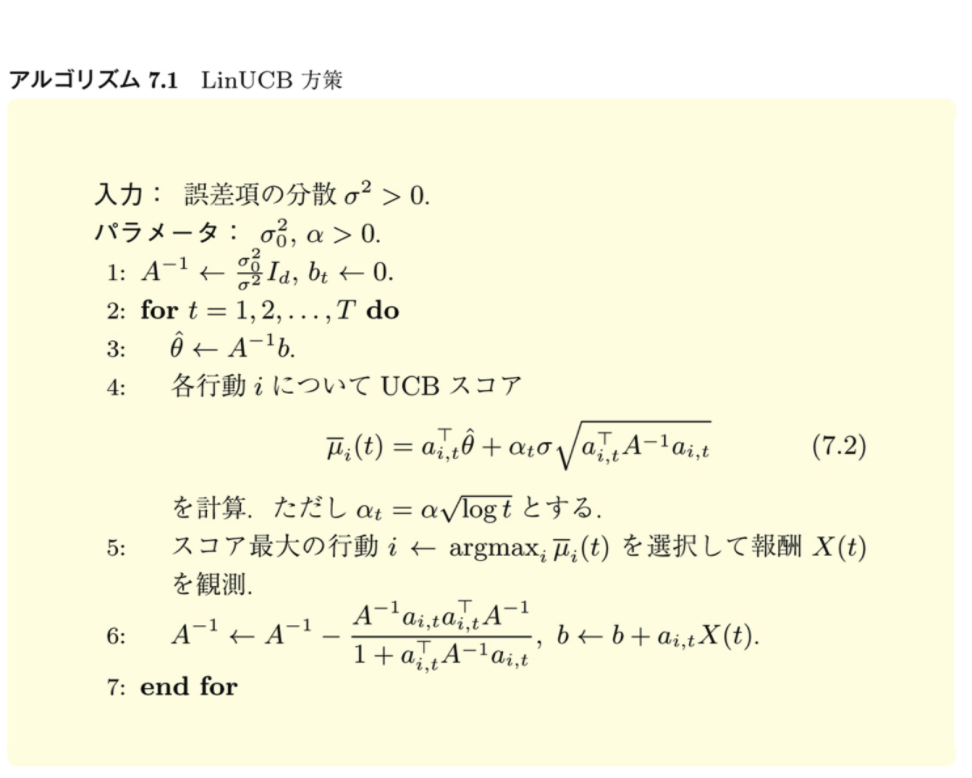
</div>

In [9]:
# アーム選択と報酬の枠の作成（各10000）
choices = np.zeros(n)
rewards = np.zeros(n)
norms = np.zeros(n)

# 誤差項
sigma = 1
eps = np.random.normal(0, sigma, n)
sigma0 = 1

# Aはアームの特徴量の積和行列(d*d)
A = np.zeros((K, d, d)) # tensor due to K arms
A_inv = np.zeros((K, d, d))

# 単位行列（リッジ）とその逆行列の作成（K*d*d）。
for a in range (0, K):
    A[a] = np.identity(d)*(sigma/sigma0)
    A_inv[a] = np.linalg.inv(A[a])

# bはアームの特徴量と報酬の積和ベクトル
b = np.zeros_like(theta)# theta(K*d)と同様のshapeを持つ、0を要素とするndarray

# 係数θ^の枠
th_hat = np.zeros_like(theta)

# 各アームのUCBスコアを入れるための枠
p = np.zeros(K)

# 信頼区間　
alpha = 0.2

#for t in tqdm(range(0, n)):
for t in range(0, n):
    
    #　各アームの計算フェイズ
    x_t = X[ｔ]   # the current context vector
    alpha_t = alpha * np.sqrt(np.log(t))
        
    #　パラメータ更新にwoodburyの公式を使う場合
    for i in range (0, K):
        th_hat[i] = A_inv[i]@b[i]
        p[i] = np.dot(x_t, th_hat[i]) + alpha_t*sigma*np.sqrt(x_t@A_inv[i]@x_t.T)       

    norms[ｔ] = np.linalg.norm(th_hat - theta,'fro')    # validate LinUCB（フロベニウスノルムを返す（全成分の二乗和のルート））
    choices[ｔ] = np.argmax(p)
    # using actual theta to figure out reward（th_hatでなくthetaである必要） 
    rewards[ｔ] = np.dot(x_t.T, theta[int(choices[ｔ])])#+eps[t]  ←誤差がない

# woodburyの公式によるパラメータ更新（パフォーマンスは悪くなる）
    A_inv[int(choices[ｔ])] -= A_inv[int(choices[ｔ])] @np.outer(x_t, x_t.T) @A_inv[int(choices[ｔ])]/(1+np.dot(x_t.T, np.dot(A_inv[int(choices[ｔ])], x_t)))
    print(A_inv[int(choices[t])])

    b[int(choices[ｔ])] += rewards[ｔ] * x_t

/var/folders/0x/mngd87jd7gs5216gvs0wlw200000gn/T/ipykernel_31884/303363937.py:37: RuntimeWarning: divide by zero encountered in log
  alpha_t = alpha * np.sqrt(np.log(t))
/var/folders/0x/mngd87jd7gs5216gvs0wlw200000gn/T/ipykernel_31884/303363937.py:37: RuntimeWarning: invalid value encountered in sqrt
  alpha_t = alpha * np.sqrt(np.log(t))


[[ 0.934467   -0.11996434 -0.09697096 -0.03577483 -0.02800275 -0.08693287
  -0.02117374 -0.0497159  -0.0782969  -0.05218466]
 [-0.11996434  0.78039396 -0.17751449 -0.06548921 -0.05126168 -0.15913882
  -0.03876054 -0.09100965 -0.14332987 -0.09552894]
 [-0.09697096 -0.17751449  0.85650943 -0.052937   -0.04143644 -0.12863693
  -0.03133136 -0.07356597 -0.11585806 -0.07721906]
 [-0.03577483 -0.06548921 -0.052937    0.98047032 -0.01528686 -0.04745715
  -0.01155887 -0.02714019 -0.04274272 -0.0284879 ]
 [-0.02800275 -0.05126168 -0.04143644 -0.01528686  0.98803421 -0.03714708
  -0.0090477  -0.02124399 -0.03345687 -0.02229891]
 [-0.08693287 -0.15913882 -0.12863693 -0.04745715 -0.03714708  0.8846791
  -0.02808805 -0.06595069 -0.10386484 -0.06922562]
 [-0.02117374 -0.03876054 -0.03133136 -0.01155887 -0.0090477  -0.02808805
   0.99315875 -0.01606323 -0.02529777 -0.01686089]
 [-0.0497159  -0.09100965 -0.07356597 -0.02714019 -0.02124399 -0.06595069
  -0.01606323  0.96228357 -0.0593991  -0.03958933]
 

  -0.0016411  -0.0083737   0.00197636  0.04539379]]
[[ 0.04385614 -0.00517271  0.00235371 -0.00215124 -0.00575537 -0.00768808
  -0.00672745 -0.00224283 -0.0068395  -0.00781216]
 [-0.00517271  0.04672542 -0.00473825 -0.0013782  -0.00771511 -0.00679253
  -0.00690398  0.00202134 -0.0053862  -0.00763841]
 [ 0.00235371 -0.00473825  0.04054681 -0.00313684 -0.00346403 -0.00453248
  -0.007481   -0.00375772 -0.00784017 -0.00876068]
 [-0.00215124 -0.0013782  -0.00313684  0.04425767 -0.00714535 -0.00826514
  -0.00065031 -0.00397713 -0.00726132 -0.00564518]
 [-0.00575537 -0.00771511 -0.00346403 -0.00714535  0.04200217 -0.00407571
  -0.00475818 -0.00324613 -0.00114418 -0.00433606]
 [-0.00768808 -0.00679253 -0.00453248 -0.00826514 -0.00407571  0.04360303
   0.00024902 -0.00935679 -0.00630829  0.00078148]
 [-0.00672745 -0.00690398 -0.007481   -0.00065031 -0.00475818  0.00024902
   0.04256155 -0.00731743 -0.00561701 -0.00190108]
 [-0.00224283  0.00202134 -0.00375772 -0.00397713 -0.00324613 -0.00935679

  -0.0036334  -0.00276343  0.00091759  0.02475604]]
[[ 0.02379167 -0.00194228  0.00019505 -0.00075439 -0.00395573 -0.00312565
  -0.00272901 -0.00082958 -0.00507363 -0.0035608 ]
 [-0.00194228  0.02600067 -0.00216148 -0.00117176 -0.00332312 -0.00372914
  -0.00263832 -0.0003534  -0.0040815  -0.00359513]
 [ 0.00019505 -0.00216148  0.02213966 -0.00285193 -0.00186789 -0.00291944
  -0.00220879 -0.00318905 -0.00332044 -0.00461341]
 [-0.00075439 -0.00117176 -0.00285193  0.02572876 -0.00388632 -0.00504569
  -0.00107118 -0.00148916 -0.0034643  -0.00334039]
 [-0.00395573 -0.00332312 -0.00186789 -0.00388632  0.02371072 -0.00337732
  -0.00236245 -0.00184673 -0.00066921 -0.00306327]
 [-0.00312565 -0.00372914 -0.00291944 -0.00504569 -0.00337732  0.0249267
  -0.0009298  -0.00462656 -0.00304114  0.00041441]
 [-0.00272901 -0.00263832 -0.00220879 -0.00107118 -0.00236245 -0.0009298
   0.0236501  -0.00348411 -0.00441278 -0.00363579]
 [-0.00082958 -0.0003534  -0.00318905 -0.00148916 -0.00184673 -0.00462656
 

   5.23474932e-03  5.30428884e-02]]
[[ 1.65955342e-02 -8.57420986e-04 -9.16970700e-04 -8.01362092e-04
  -2.48590539e-03 -2.39678028e-03 -2.36718414e-03  5.36046830e-06
  -2.97208997e-03 -1.93771309e-03]
 [-8.57420986e-04  1.68003729e-02 -1.53652462e-03 -1.14409555e-03
  -2.57358374e-03 -2.34547353e-03 -2.23395717e-03  4.15952920e-04
  -2.81148346e-03 -1.65111943e-03]
 [-9.16970700e-04 -1.53652462e-03  1.54745032e-02 -1.71731479e-03
  -1.07223333e-03 -2.16556546e-03 -1.08269271e-03 -2.32640167e-03
  -1.98648825e-03 -2.94906847e-03]
 [-8.01362092e-04 -1.14409555e-03 -1.71731479e-03  1.80128952e-02
  -2.74964932e-03 -3.02897096e-03 -1.25685588e-03 -5.62468599e-04
  -2.55949158e-03 -1.78075461e-03]
 [-2.48590539e-03 -2.57358374e-03 -1.07223333e-03 -2.74964932e-03
   1.59125018e-02 -1.83755016e-03 -1.61784006e-03 -2.31470457e-03
   2.44666613e-05 -2.40163201e-03]
 [-2.39678028e-03 -2.34547353e-03 -2.16556546e-03 -3.02897096e-03
  -1.83755016e-03  1.71205007e-02 -1.33389231e-03 -3.00779941e-

  -0.00132585 -0.00165634 -0.00053527  0.01220196]]
[[ 0.0127555  -0.00060296 -0.00092502 -0.00053613 -0.00249051 -0.00168805
  -0.00181185  0.00038804 -0.00213356 -0.0013907 ]
 [-0.00060296  0.01291533 -0.00098864 -0.00065372 -0.00187661 -0.00167801
  -0.00147101 -0.00015209 -0.00248034 -0.00134153]
 [-0.00092502 -0.00098864  0.01165132 -0.00138107 -0.00085034 -0.00167112
  -0.00110714 -0.00141603 -0.0015627  -0.00195271]
 [-0.00053613 -0.00065372 -0.00138107  0.01360552 -0.00199726 -0.00228249
  -0.00130276  0.00026511 -0.00223685 -0.0015634 ]
 [-0.00249051 -0.00187661 -0.00085034 -0.00199726  0.01244896 -0.00124436
  -0.00126622 -0.00208283  0.00020457 -0.00182343]
 [-0.00168805 -0.00167801 -0.00167112 -0.00228249 -0.00124436  0.01279524
  -0.00100003 -0.00226502 -0.0015083  -0.00027614]
 [-0.00181185 -0.00147101 -0.00110714 -0.00130276 -0.00126622 -0.00100003
   0.0115464  -0.00154845 -0.00126037 -0.00132232]
 [ 0.00038804 -0.00015209 -0.00141603  0.00026511 -0.00208283 -0.00226502

   0.00071001 -0.00847596  0.00433329  0.03097413]]
[[ 0.03426845 -0.00445433 -0.00599127 -0.00094061 -0.0097112  -0.0057987
  -0.00889923  0.00298088 -0.01204587 -0.00530031]
 [-0.00445433  0.0300685  -0.00696443 -0.00097249 -0.00340118 -0.00496714
  -0.00290826 -0.00118802 -0.00512557 -0.00466248]
 [-0.00599127 -0.00696443  0.0370143  -0.00762712  0.00363424  0.00028403
   0.00075105 -0.01003403  0.0031475  -0.00016123]
 [-0.00094061 -0.00097249 -0.00762712  0.03399242 -0.00668807 -0.00801741
  -0.00693024  0.0011898  -0.01139251 -0.00709873]
 [-0.0097112  -0.00340118  0.00363424 -0.00668807  0.04632357  0.00157093
   0.00527939 -0.02263285  0.01701987  0.0025149 ]
 [-0.0057987  -0.00496714  0.00028403 -0.00801741  0.00157093  0.03409498
   0.00333621 -0.01169161  0.00659207 -0.00022312]
 [-0.00889923 -0.00290826  0.00075105 -0.00693024  0.00527939  0.00333621
   0.0365118  -0.0160995   0.01002761  0.00075448]
 [ 0.00298088 -0.00118802 -0.01003403  0.0011898  -0.02263285 -0.01169161


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[ 3.44122398e-03 -2.12944659e-04 -2.94263773e-04 -1.39063634e-04
  -6.34556487e-04 -4.54219003e-04 -4.16582954e-04  2.87034113e-04
  -7.54113485e-04 -2.69548936e-04]
 [-2.12944659e-04  3.31359710e-03 -3.70916519e-04 -9.86742444e-05
  -4.41625802e-04 -4.30969450e-04 -4.58081257e-04  8.16992614e-05
  -5.32170806e-04 -4.21712078e-04]
 [-2.94263773e-04 -3.70916519e-04  3.14089407e-03 -3.97035609e-04
  -2.89878945e-04 -3.10544299e-04 -3.74610789e-04 -4.19677958e-04
  -3.70733817e-04 -3.76882935e-04]
 [-1.39063634e-04 -9.86742444e-05 -3.97035609e-04  3.50538924e-03
  -5.23638218e-04 -5.94164282e-04 -5.29213903e-04  1.99756738e-04
  -5.34482983e-04 -3.23549888e-04]
 [-6.34556487e-04 -4.41625802e-04 -2.89878945e-04 -5.23638218e-04
   3.41896382e-03 -3.44209156e-04 -4.23001787e-04 -8.84258230e-04
   1.30870581e-04 -3.58809862e-04]
 [-4.54219003e-04 -4.30969450e-04 -3.10544299e-04 -5.94164282e-04
  -3.44209156e-04  3.30042985e-03 -1.44132761e-04 -5.54825126e-04
  -3.64037839e-04 -2.86067201e-04

   1.35817315e-03  8.12109964e-03]]
[[ 9.27631485e-03 -6.25751532e-04 -1.71174752e-03 -1.48598287e-04
  -3.44793338e-03 -1.81126370e-03 -2.34287088e-03  1.45668920e-03
  -4.48918751e-03 -1.55768037e-03]
 [-6.25751532e-04  8.02043102e-03 -1.42057432e-03 -6.67116842e-04
  -7.61936366e-04 -1.08396265e-03 -1.03256928e-03 -8.45634203e-04
  -1.52716014e-03 -9.27250155e-04]
 [-1.71174752e-03 -1.42057432e-03  9.07537699e-03 -1.41571904e-03
   1.18902518e-03 -7.17191914e-05  1.26770253e-04 -3.30224405e-03
   1.39786853e-03  1.05111318e-04]
 [-1.48598287e-04 -6.67116842e-04 -1.41571904e-03  8.84272032e-03
  -2.45792029e-03 -1.77580540e-03 -1.70272728e-03  3.77213952e-04
  -3.20424005e-03 -1.53648432e-03]
 [-3.44793338e-03 -7.61936366e-04  1.18902518e-03 -2.45792029e-03
   1.52270287e-02  9.75583184e-04  1.73747536e-03 -7.63364834e-03
   7.01010184e-03  6.42285253e-04]
 [-1.81126370e-03 -1.08396265e-03 -7.17191914e-05 -1.77580540e-03
   9.75583184e-04  9.45055300e-03  4.05605684e-04 -3.43738865e-

  -2.91127933e-04  2.74751288e-03]]
[[ 8.79071510e-03 -5.69246170e-04 -1.65173685e-03 -1.26474794e-04
  -3.29771875e-03 -1.71639452e-03 -2.19733860e-03  1.45598421e-03
  -4.30034966e-03 -1.55224772e-03]
 [-5.69246170e-04  7.60004648e-03 -1.35588063e-03 -5.87604502e-04
  -6.92260445e-04 -1.04760078e-03 -9.97228653e-04 -8.81855299e-04
  -1.34268576e-03 -8.94248099e-04]
 [-1.65173685e-03 -1.35588063e-03  8.58733570e-03 -1.35327492e-03
   1.11980177e-03 -2.05882842e-05  1.13192581e-04 -3.10999045e-03
   1.37551884e-03  1.08481134e-04]
 [-1.26474794e-04 -5.87604502e-04 -1.35327492e-03  8.37434438e-03
  -2.38660798e-03 -1.72611599e-03 -1.60163774e-03  4.23238835e-04
  -3.01903664e-03 -1.52489493e-03]
 [-3.29771875e-03 -6.92260445e-04  1.11980177e-03 -2.38660798e-03
   1.43942673e-02  8.58914821e-04  1.72161396e-03 -7.20776234e-03
   6.59200358e-03  6.43575062e-04]
 [-1.71639452e-03 -1.04760078e-03 -2.05882842e-05 -1.72611599e-03
   8.58914821e-04  8.94072777e-03  4.59986395e-04 -3.23010860e-

   1.25159528e-03  7.46748972e-03]]
[[ 2.87004866e-03 -1.50064587e-04 -2.67285842e-04 -1.30349627e-04
  -5.29090197e-04 -3.70565315e-04 -3.22554943e-04  2.52123213e-04
  -6.45025603e-04 -2.46113282e-04]
 [-1.50064587e-04  2.77213868e-03 -3.06832556e-04 -4.80028092e-05
  -3.74686681e-04 -3.60969536e-04 -4.00856416e-04  4.76069476e-05
  -4.71988731e-04 -3.56534037e-04]
 [-2.67285842e-04 -3.06832556e-04  2.64553053e-03 -3.66506495e-04
  -2.54115856e-04 -2.57430106e-04 -3.13588034e-04 -3.59431721e-04
  -2.82964450e-04 -3.00885658e-04]
 [-1.30349627e-04 -4.80028092e-05 -3.66506495e-04  2.94567582e-03
  -4.47706629e-04 -5.00008348e-04 -4.27417247e-04  1.87091524e-04
  -4.46670380e-04 -2.79731691e-04]
 [-5.29090197e-04 -3.74686681e-04 -2.54115856e-04 -4.47706629e-04
   2.89101630e-03 -3.15547733e-04 -3.24286634e-04 -7.41840800e-04
   1.15725252e-04 -3.22054458e-04]
 [-3.70565315e-04 -3.60969536e-04 -2.57430106e-04 -5.00008348e-04
  -3.15547733e-04  2.74366913e-03 -1.16028828e-04 -4.57021898e-

[[ 2.73965927e-03 -1.40730466e-04 -2.66118738e-04 -1.16107604e-04
  -5.13072442e-04 -3.55425765e-04 -3.10202404e-04  2.46561327e-04
  -5.97884189e-04 -2.40480820e-04]
 [-1.40730466e-04  2.64625459e-03 -2.87829395e-04 -5.71696237e-05
  -3.39579054e-04 -3.37718819e-04 -3.88560979e-04  3.66989606e-05
  -4.52322140e-04 -3.45591332e-04]
 [-2.66118738e-04 -2.87829395e-04  2.52240014e-03 -3.54844083e-04
  -2.46400355e-04 -2.53340142e-04 -2.71053375e-04 -3.24169886e-04
  -2.82969612e-04 -2.84201276e-04]
 [-1.16107604e-04 -5.71696237e-05 -3.54844083e-04  2.80730494e-03
  -4.27345371e-04 -4.80960952e-04 -4.06879810e-04  1.63224355e-04
  -4.12055537e-04 -2.57401718e-04]
 [-5.13072442e-04 -3.39579054e-04 -2.46400355e-04 -4.27345371e-04
   2.75645085e-03 -2.87541584e-04 -3.22463146e-04 -7.17848470e-04
   1.14404908e-04 -3.09364790e-04]
 [-3.55425765e-04 -3.37718819e-04 -2.53340142e-04 -4.80960952e-04
  -2.87541584e-04  2.62425257e-03 -1.12115236e-04 -4.35326437e-04
  -2.67334276e-04 -2.30233192e-04

   1.00144698e-03  6.84727867e-03]]
[[ 2.62655175e-03 -1.31639371e-04 -2.73679091e-04 -9.97479597e-05
  -4.81952026e-04 -3.19132306e-04 -3.00259609e-04  2.41245235e-04
  -5.83497945e-04 -2.42328910e-04]
 [-1.31639371e-04  2.53818625e-03 -2.76633633e-04 -4.89778672e-05
  -3.34729040e-04 -3.29789384e-04 -3.70026430e-04  3.92524977e-05
  -4.35056931e-04 -3.26888956e-04]
 [-2.73679091e-04 -2.76633633e-04  2.41689660e-03 -3.37116321e-04
  -2.45000003e-04 -2.26006640e-04 -2.57017210e-04 -3.07519807e-04
  -2.66725566e-04 -2.73377684e-04]
 [-9.97479597e-05 -4.89778672e-05 -3.37116321e-04  2.69278110e-03
  -4.03777403e-04 -4.73930898e-04 -3.98640818e-04  1.56922588e-04
  -3.99108696e-04 -2.51869107e-04]
 [-4.81952026e-04 -3.34729040e-04 -2.45000003e-04 -4.03777403e-04
   2.64396013e-03 -2.88605226e-04 -3.14552064e-04 -6.81188294e-04
   1.19365478e-04 -2.91655774e-04]
 [-3.19132306e-04 -3.29789384e-04 -2.26006640e-04 -4.73930898e-04
  -2.88605226e-04  2.51088558e-03 -1.10635675e-04 -4.16032611e-

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[ 5.12530959e-03 -3.24906770e-04 -1.06945486e-03 -2.46939121e-04
  -1.90288796e-03 -9.47708128e-04 -1.12624467e-03  7.37044600e-04
  -2.41107950e-03 -7.62094365e-04]
 [-3.24906770e-04  4.49557733e-03 -7.62498404e-04 -3.97181431e-04
  -4.09858804e-04 -6.88245489e-04 -5.74500713e-04 -4.09395082e-04
  -9.71105617e-04 -6.29515173e-04]
 [-1.06945486e-03 -7.62498404e-04  5.08043073e-03 -6.18949669e-04
   6.73615856e-04  4.39289969e-05  1.89166689e-04 -2.08488732e-03
   9.88363671e-04 -5.93845383e-05]
 [-2.46939121e-04 -3.97181431e-04 -6.18949669e-04  4.76225302e-03
  -1.27437807e-03 -8.42512908e-04 -8.68561432e-04  9.06967951e-05
  -1.46778129e-03 -7.39230193e-04]
 [-1.90288796e-03 -4.09858804e-04  6.73615856e-04 -1.27437807e-03
   8.83422191e-03  3.98628658e-04  8.98753442e-04 -4.37895416e-03
   4.01968020e-03  3.18667647e-04]
 [-9.47708128e-04 -6.88245489e-04  4.39289969e-05 -8.42512908e-04
   3.98628658e-04  4.94353318e-03  1.49212730e-04 -1.80225287e-03
   8.28768081e-04 -5.58293571e-06

[[ 1.70756548e-03 -7.97043016e-05 -1.78833305e-04 -4.43708590e-05
  -3.21872667e-04 -2.03217925e-04 -2.08575850e-04  1.66726764e-04
  -3.87121161e-04 -1.62263422e-04]
 [-7.97043016e-05  1.65941783e-03 -1.85859310e-04 -3.78246015e-05
  -2.23769356e-04 -2.09421385e-04 -2.44545578e-04  3.76614233e-05
  -2.84004870e-04 -2.17847525e-04]
 [-1.78833305e-04 -1.85859310e-04  1.57902936e-03 -2.00460301e-04
  -1.57181593e-04 -1.77421707e-04 -1.68716827e-04 -1.85509632e-04
  -1.61296264e-04 -1.82493647e-04]
 [-4.43708590e-05 -3.78246015e-05 -2.00460301e-04  1.73613130e-03
  -2.54020754e-04 -3.10207711e-04 -2.72607236e-04  1.48755500e-04
  -2.70575672e-04 -2.02791613e-04]
 [-3.21872667e-04 -2.23769356e-04 -1.57181593e-04 -2.54020754e-04
   1.71496703e-03 -1.84938163e-04 -1.86303715e-04 -4.50566579e-04
   5.97172702e-05 -1.86934106e-04]
 [-2.03217925e-04 -2.09421385e-04 -1.77421707e-04 -3.10207711e-04
  -1.84938163e-04  1.61269711e-03 -5.57551449e-05 -2.70685796e-04
  -1.68985506e-04 -1.10355112e-04

/opt/anaconda3/envs/gym/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

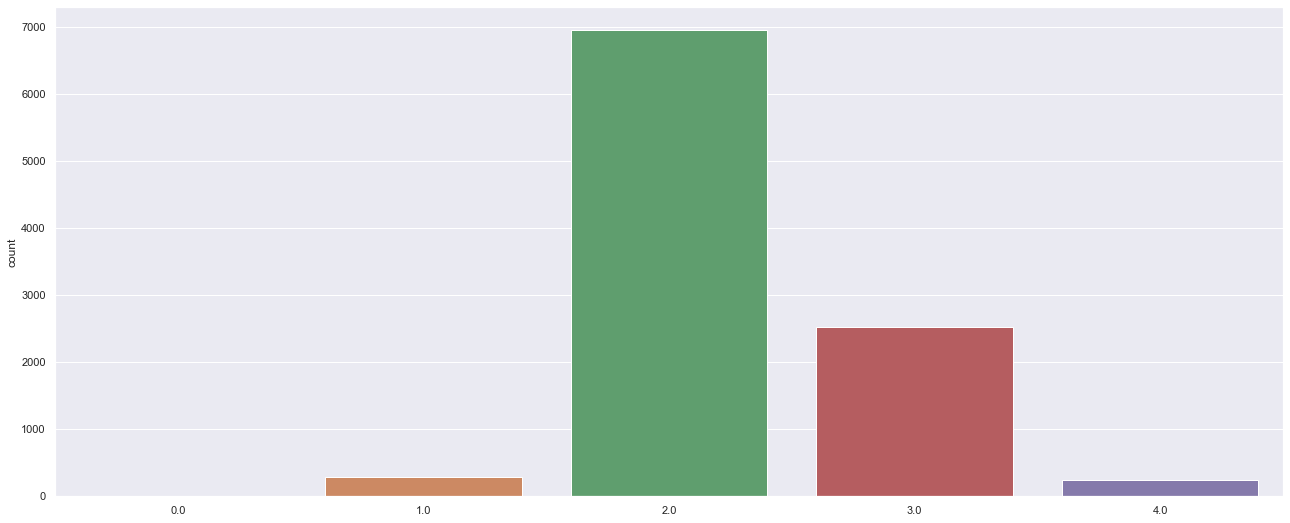

In [10]:
sns.countplot(choices)

Text(0.5, 1.0, 'Cumulative Regret')

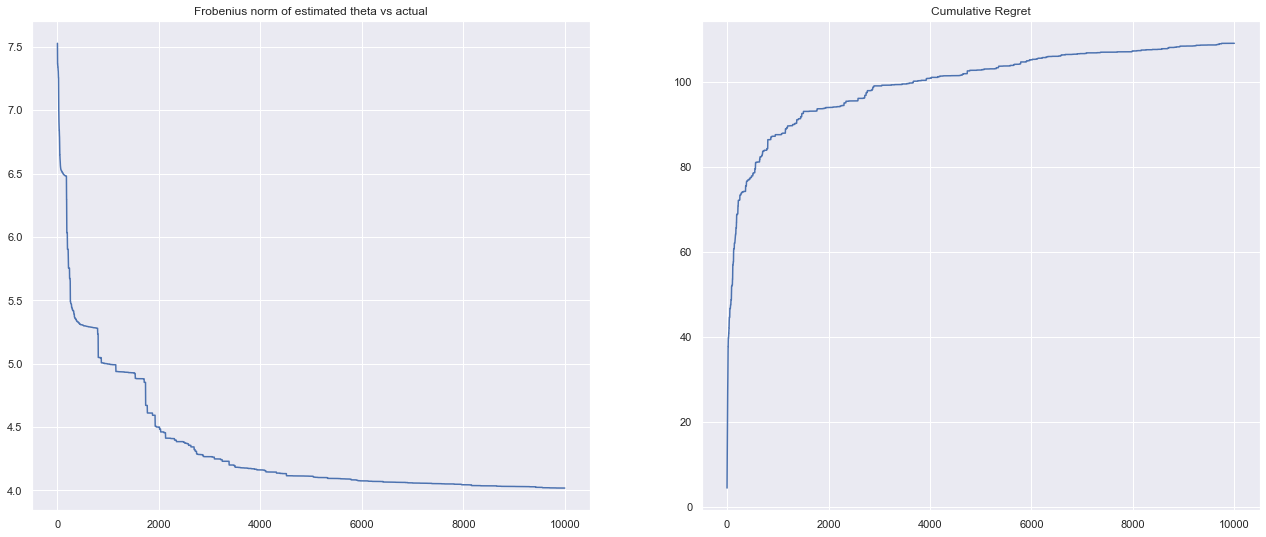

In [11]:
plt.subplot(121)
plt.plot(norms);
plt.title("Frobenius norm of estimated theta vs actual")

plt.subplot(122)
regret = (y.max(axis=1) - rewards)

plt.plot(regret.cumsum())
plt.title("Cumulative Regret")

## パラメータ更新における外積とwoodburyの公式の比較

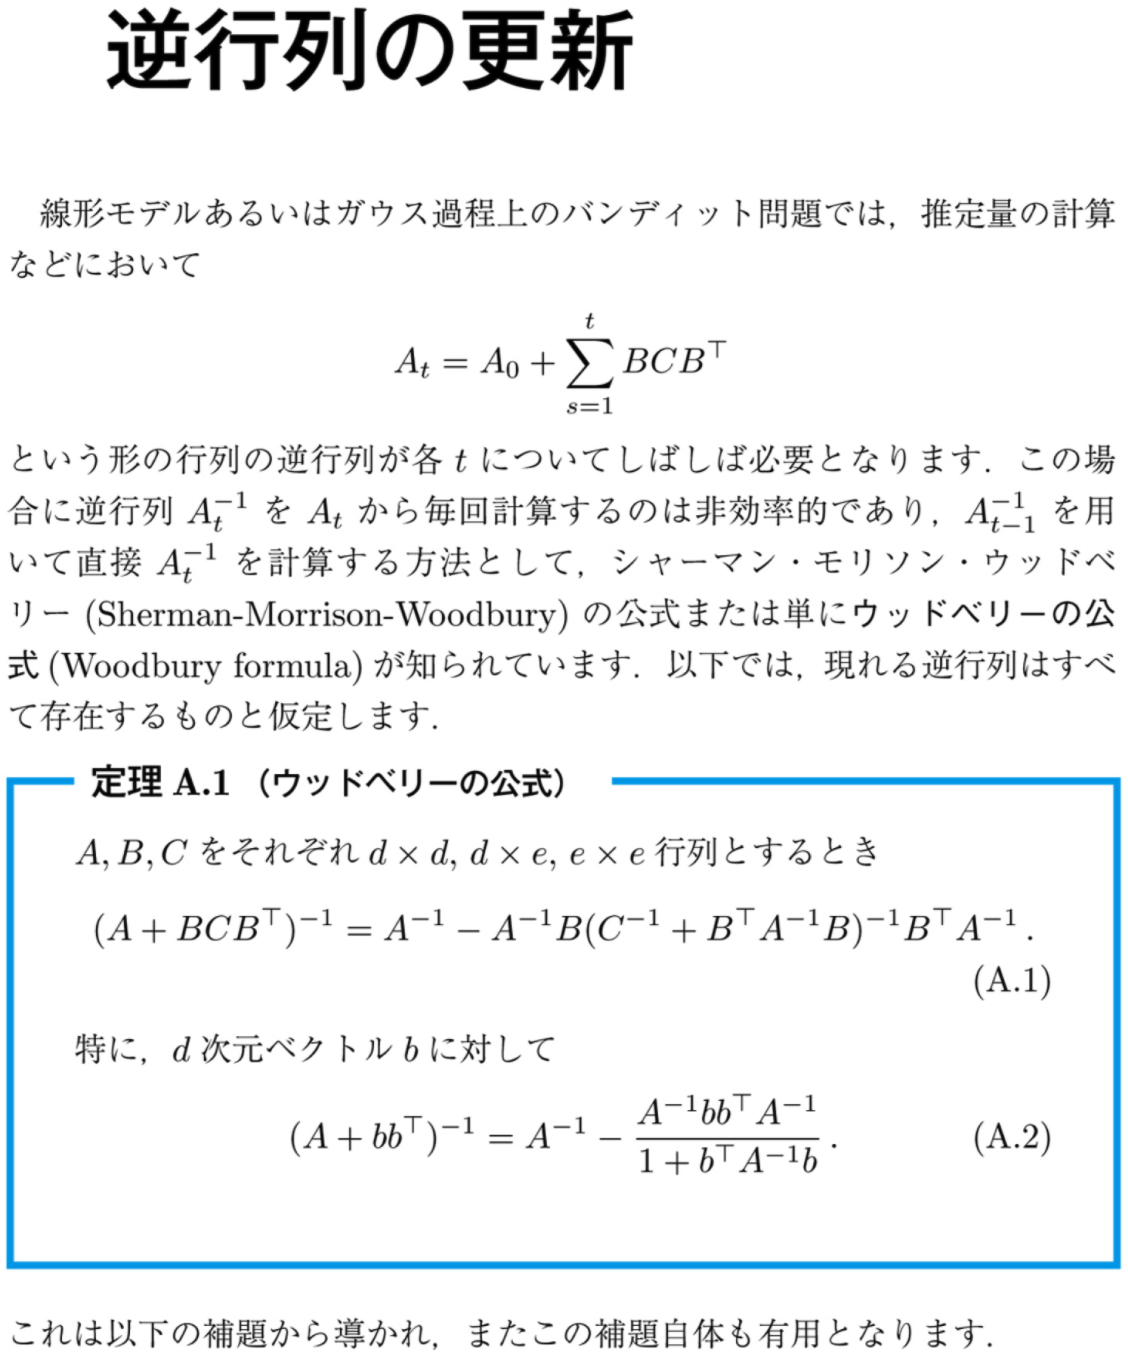